In [ ]:
import pandas as pd
df = pd.read_parquet("device_rpcs_all_20251015_130142.parquet")
print(df.head())
print(df.info())
import pandas as pd
import os


# Basic info
num_rows, num_cols = df.shape
file_size_mb = os.path.getsize("device_rpcs_all_20251015_130142.parquet") 
print(f"Rows: {num_rows:,}")
print(f"Columns: {num_cols}")
print(f"File size: {file_size_mb:.2f} MB")
print("\nColumn names:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nPreview of data:")
print(df.head())

# compare with CSV
csv_path = "device_rpcs_all.csv"
df.to_csv(csv_path, index=False)
csv_size_mb = os.path.getsize(csv_path) / (1024 * 1024)
print(f"\nCSV file size (for comparison): {csv_size_mb:.2f} MB")




      id             uuid                   timestamp     rpc  \
0  26759  359404230124662   2025-08-27T13:54:15.07788  unlock   
1  26198  359404230124662  2025-08-24T12:15:17.883128  unlock   
2  26197  359404230124662  2025-08-24T12:13:41.625633  unlock   
3  26196  359404230124662  2025-08-24T12:09:12.521266  unlock   
4  26195  359404230124662  2025-08-24T12:07:17.086796  unlock   

                ack_timestamp ack_status  
0  2025-08-27T13:54:15.969338          0  
1  2025-08-24T12:15:18.690713          0  
2  2025-08-24T12:13:41.814389          0  
3  2025-08-24T12:09:13.253281          0  
4  2025-08-24T12:07:23.506809          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8451 entries, 0 to 8450
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             8451 non-null   int32 
 1   uuid           8451 non-null   object
 2   timestamp      8451 non-null   object
 3   rpc            8451 non-n

In [ ]:

# Преобразование временных меток
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["ack_timestamp"] = pd.to_datetime(df["ack_timestamp"], errors="coerce")


df["response_time"] = (df["ack_timestamp"] - df["timestamp"]).dt.total_seconds()

# Сохранение результата в новый CSV-файл
df.to_csv("device_rpcs_with_response_time.csv", index=False)

print("✅ Готово! Файл сохранён как 'device_rpcs_with_response_time.csv'")


✅ Готово! Файл сохранён как 'device_rpcs_with_response_time.csv'


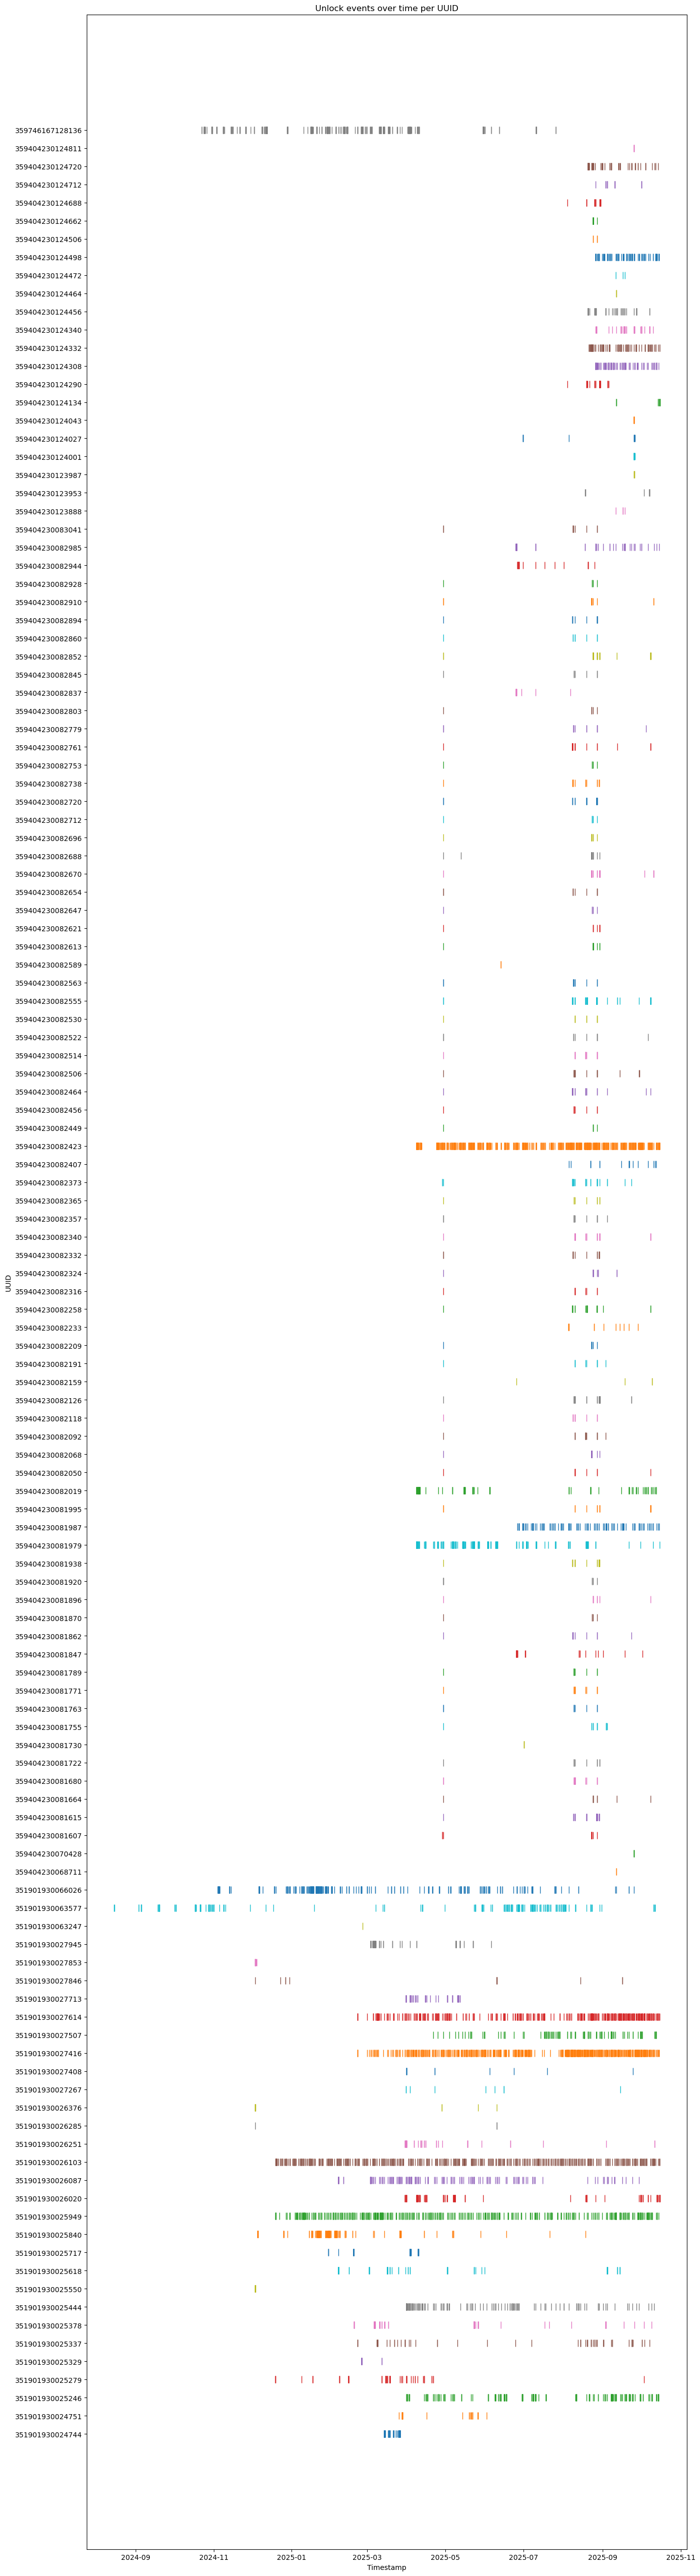

In [6]:
import matplotlib.pyplot as plt

# Загружаем данные
df = pd.read_csv("device_rpcs_with_response_time.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Фильтруем только события 'unlock'
unlock_df = df[df["rpc"] == "unlock"].copy()

# Сортируем по uuid и времени
unlock_df.sort_values(by=["uuid", "timestamp"], inplace=True)

# Присваиваем каждой uuid числовую позицию на оси Y
uuids = unlock_df["uuid"].unique()
uuid_to_y = {uuid: i for i, uuid in enumerate(uuids)}

# Создаём график
plt.figure(figsize=(14, len(uuids) * 0.4))  # высота зависит от количества uuid

for uuid, group in unlock_df.groupby("uuid"):
    y = uuid_to_y[uuid]
    plt.plot(group["timestamp"], [y] * len(group), '|', markersize=10, label=uuid)

plt.yticks(range(len(uuids)), uuids)
plt.title("Unlock events over time per UUID")
plt.xlabel("Timestamp")
plt.ylabel("UUID")
plt.tight_layout()
plt.show()


✅ Saved 6056 lines into file 'device_rpcs_unlocks_over_100.csv'
📊 Filtration result of 'unlock':
• Total devices: 128
• Devices after filtration (>100 событий): 19 (14.84%)
• Total events: 8445
• Events after filtration (for active devices): 6056 (71.71%)


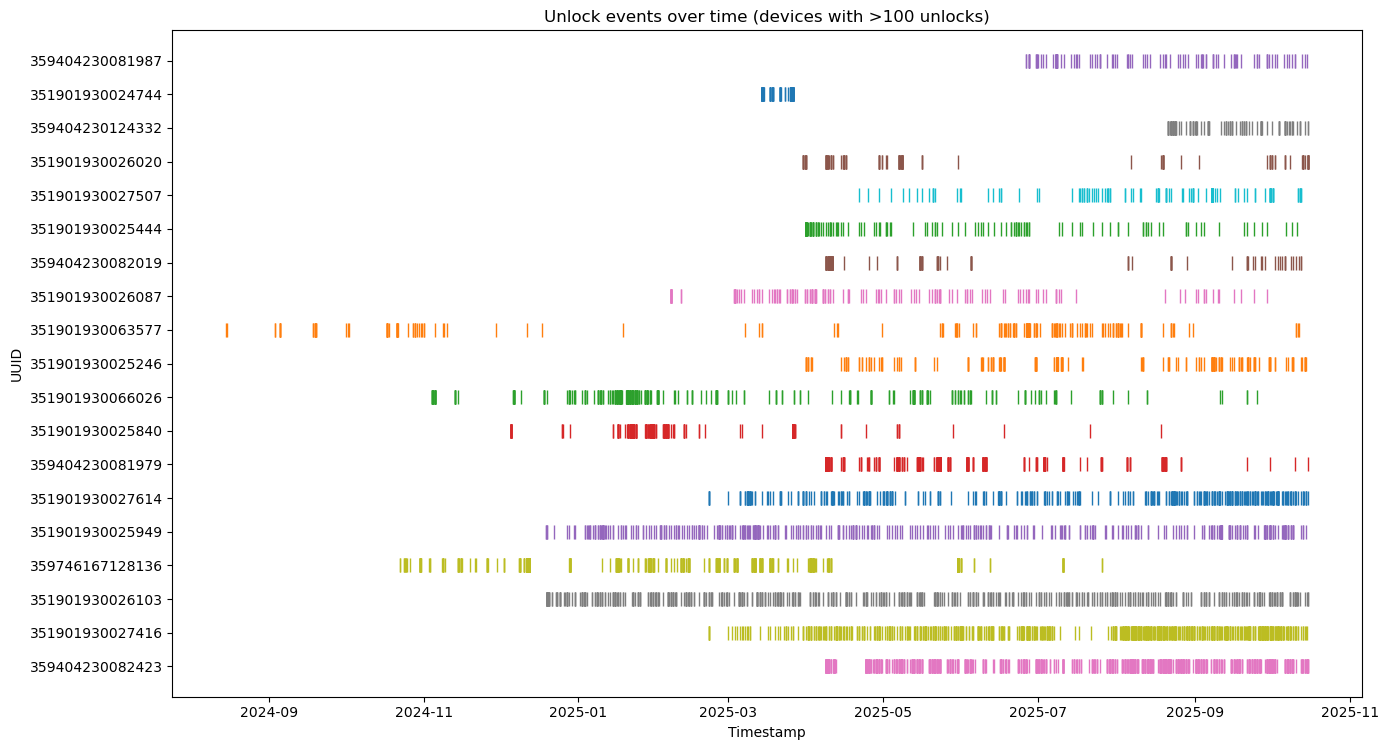

In [26]:

import matplotlib.pyplot as plt

# Загружаем данные
df = pd.read_csv("device_rpcs_with_response_time.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Фильтруем только 'unlock'
unlock_df = df[df["rpc"] == "unlock"].copy()

# Считаем количество событий по каждому uuid
unlock_counts = unlock_df["uuid"].value_counts()

# Оставляем только устройства с >100 событий
active_uuids = unlock_counts[unlock_counts > 100].index
filtered_df = unlock_df[unlock_df["uuid"].isin(active_uuids)].copy()

# Фильтруем только unlock-события от этих устройств
filtered_unlocks = unlock_df[unlock_df["uuid"].isin(active_uuids)].copy()

# Сохраняем результат в новый CSV
filtered_unlocks.to_csv("device_rpcs_unlocks_over_100.csv", index=False)

print(f"✅ Saved {len(filtered_unlocks)} lines into file 'device_rpcs_unlocks_over_100.csv'")
num_devices_left = len(active_uuids)

# Подсчитываем количество событий до и после фильтрации
total_events = len(unlock_df)
filtered_events = len(unlock_df[unlock_df["uuid"].isin(active_uuids)])

# Подсчитываем количество устройств до и после
total_devices = unlock_counts.count()
filtered_devices = len(active_uuids)

# Рассчитываем проценты
percent_devices = filtered_devices / total_devices * 100
percent_events = filtered_events / total_events * 100

# Красивый вывод
print("📊 Filtration result of 'unlock':")
print(f"• Total devices: {total_devices}")
print(f"• Devices after filtration (>100 событий): {filtered_devices} ({percent_devices:.2f}%)")
print(f"• Total events: {total_events}")
print(f"• Events after filtration (for active devices): {filtered_events} ({percent_events:.2f}%)")

# Сортируем по количеству событий
sorted_uuids = unlock_counts[active_uuids].sort_values(ascending=False).index

# Назначаем позицию каждой uuid на оси Y
uuid_to_y = {uuid: i for i, uuid in enumerate(sorted_uuids)}

# Создаём график
plt.figure(figsize=(14, len(sorted_uuids) * 0.4))

for uuid, group in filtered_df.groupby("uuid"):
    y = uuid_to_y[uuid]
    plt.plot(group["timestamp"], [y] * len(group), '|', markersize=10, label=uuid)

plt.yticks(range(len(sorted_uuids)), sorted_uuids)
plt.title("Unlock events over time (devices with >100 unlocks)")
plt.xlabel("Timestamp")
plt.ylabel("UUID")
plt.tight_layout()
plt.show()



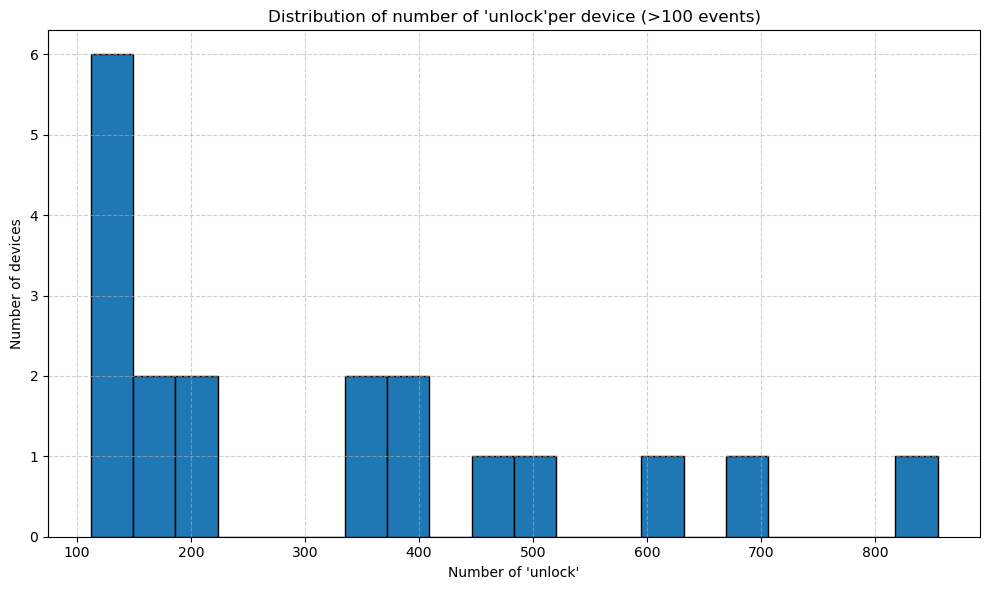

📊  Statistic per active devices:
count     19.000000
mean     318.736842
std      223.366127
min      112.000000
25%      135.500000
50%      213.000000
75%      431.500000
max      855.000000
Name: count, dtype: float64


In [27]:

# Оставляем устройства с >100 unlock
active_counts = unlock_counts[unlock_counts > 100]

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(active_counts, bins=20, edgecolor='black')
plt.title("Distribution of number of 'unlock'per device (>100 events)")
plt.xlabel("Number of 'unlock'")
plt.ylabel("Number of devices")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Дополнительно выведем статистику
print("📊  Statistic per active devices:")
print(active_counts.describe())


In [34]:

# Group by device UUID
summary = (
    df.groupby("uuid")["ack_status"]
      .agg(
          total_rpc="size",                               # counts all rows, including NaN
          successful_rpc=lambda s: s.eq(0).sum()          # count where ack_status == 0
      )
      .reset_index()
)

# Success percentage from total (including NaN rows)
summary["success_percentage"] = 100 * summary["successful_rpc"] / summary["total_rpc"]

#also include failed/unacknowledged (i.e., not 0, including NaN)
summary["failed_or_nan"] = summary["total_rpc"] - summary["successful_rpc"]

# Sort 
summary = summary.sort_values("success_percentage", ascending=False)


# Save results
summary.to_csv("rpc_success_by_uuid.csv", index=False)
print("Saved summary to rpc_success_by_uuid.csv")


Saved summary to rpc_success_by_uuid.csv


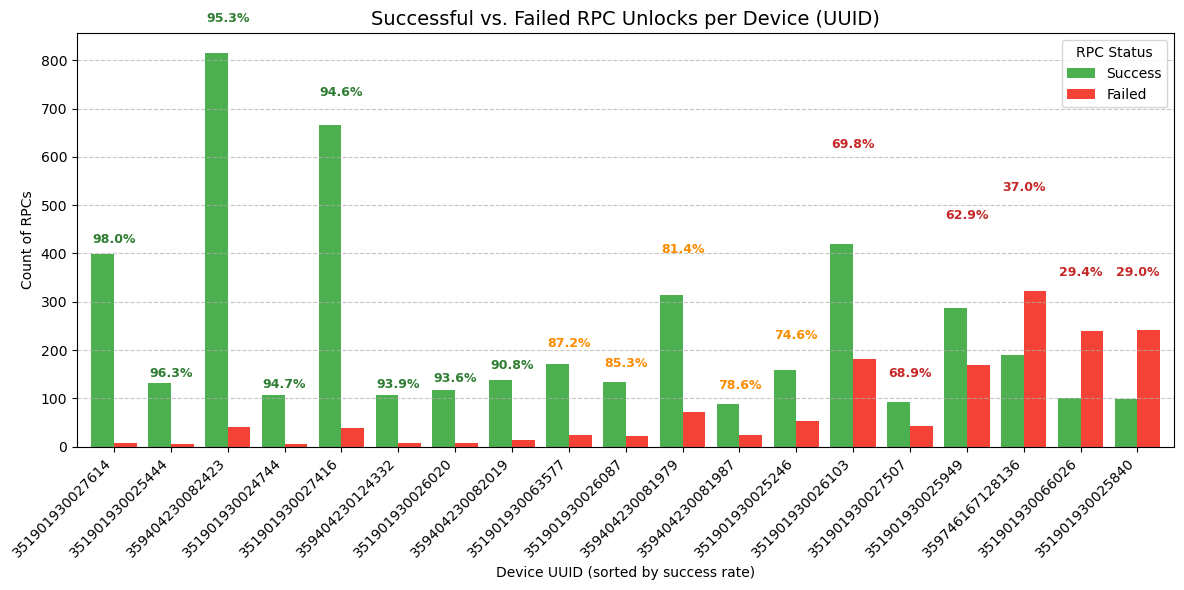

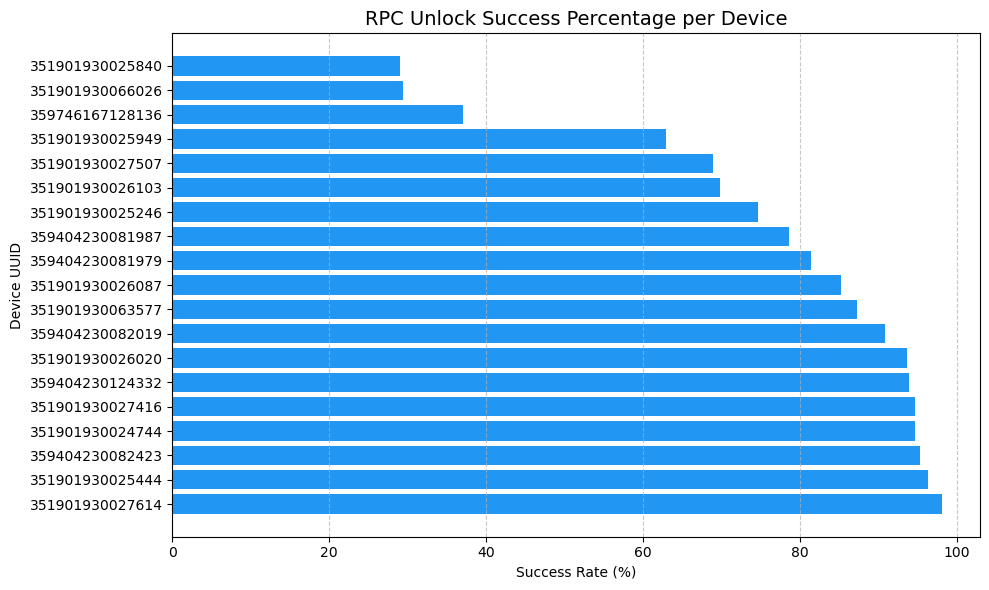

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("device_rpcs_unlocks_over_100.csv")

# Ensure required columns exist
required_columns = {"uuid", "ack_status"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"CSV must contain columns: {required_columns}")

# Convert UUID to string safely
df["uuid"] = df["uuid"].astype(str).fillna("Unknown")

# Ensure ack_status is numeric
df["ack_status"] = pd.to_numeric(df["ack_status"], errors="coerce")

# Label success or failure
df["status"] = df["ack_status"].apply(lambda x: "Success" if x == 0 else "Failed")

# Group and summarize
stats = df.groupby(["uuid", "status"]).size().unstack(fill_value=0)
stats["Success_%"] = 100 * stats["Success"] / (stats["Success"] + stats["Failed"])

# --- Sort by success percentage ---
stats = stats.sort_values("Success_%", ascending=False)

# --- Plot 1: Success vs Failed RPC counts (sorted) ---
fig, ax = plt.subplots(figsize=(12, 6))
bars = stats[["Success", "Failed"]].plot(
    kind="bar",
    ax=ax,
    width=0.8,
    color=["#4CAF50", "#F44336"]
)

plt.title("Successful vs. Failed RPC Unlocks per Device (UUID)", fontsize=14)
plt.xlabel("Device UUID (sorted by success rate)")
plt.ylabel("Count of RPCs")
plt.xticks(rotation=45, ha="right")
plt.legend(title="RPC Status")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# --- Add color-coded % labels above bars ---
for i, (idx, row) in enumerate(stats.iterrows()):
    total = row["Success"] + row["Failed"]
    pct = row["Success_%"]

    if pct >= 90:
        color = "#2E7D32"  # dark green
    elif pct >= 70:
        color = "#FB8C00"  # orange
    else:
        color = "#C62828"  # red

    ax.text(
        i, total + (total * 0.02),
        f"{pct:.1f}%",
        ha='center', va='bottom',
        fontsize=9, fontweight='bold', color=color
    )

plt.tight_layout()
plt.show()

# --- Plot 2: Success percentage per device (horizontal) ---
plt.figure(figsize=(10, 6))
plt.barh(stats.index, stats["Success_%"], color="#2196F3")
plt.title("RPC Unlock Success Percentage per Device", fontsize=14)
plt.xlabel("Success Rate (%)")
plt.ylabel("Device UUID")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


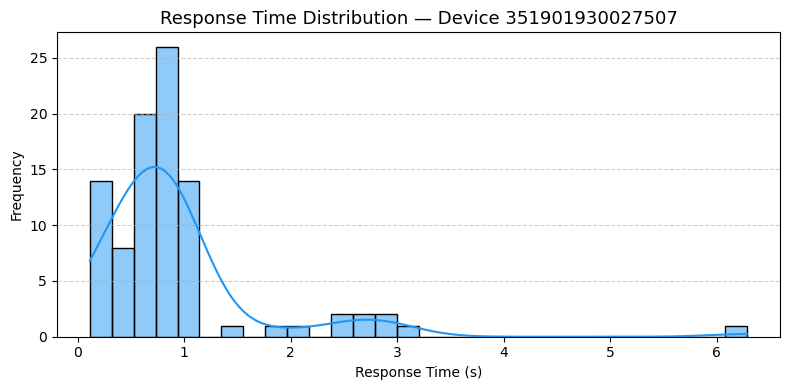

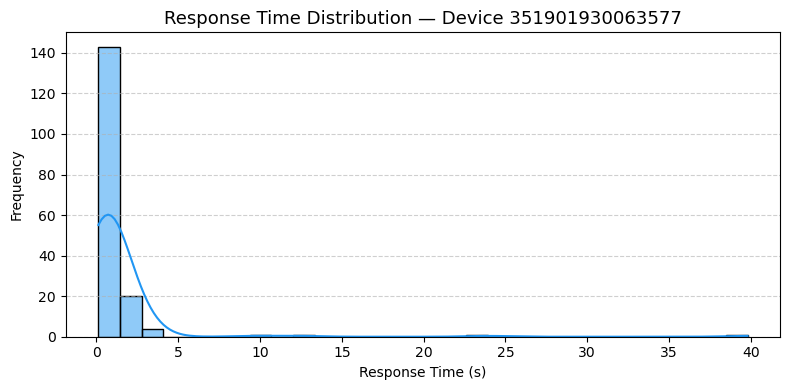

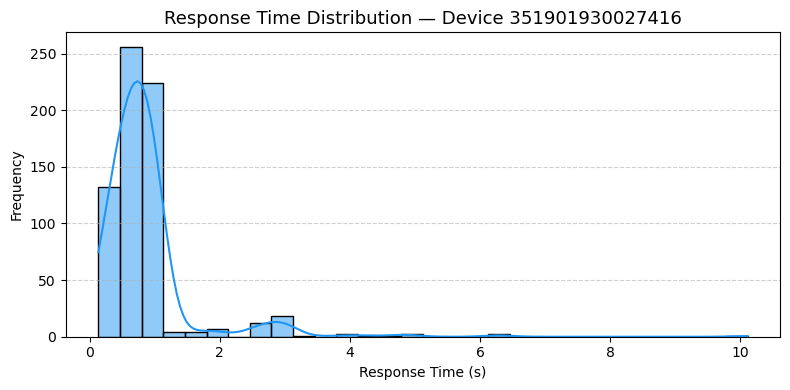

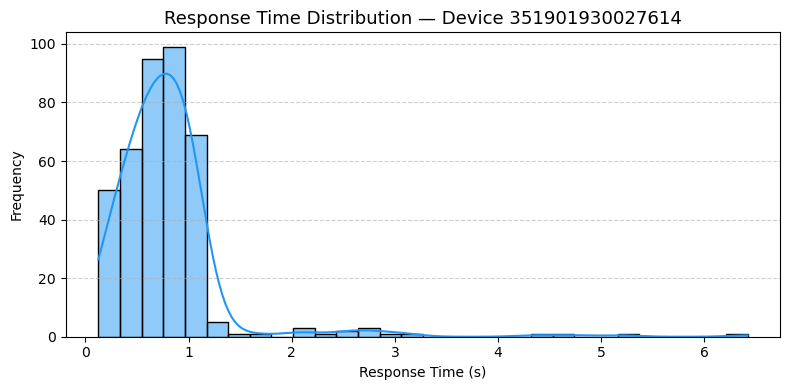

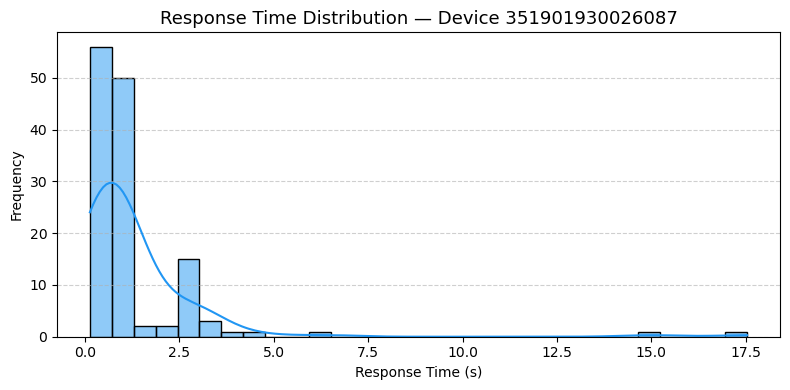

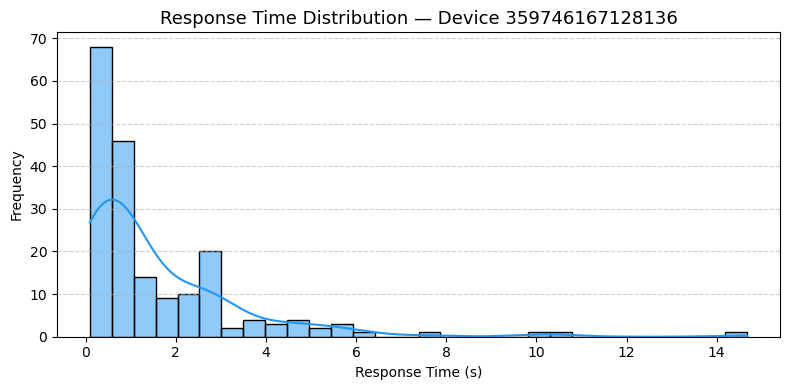

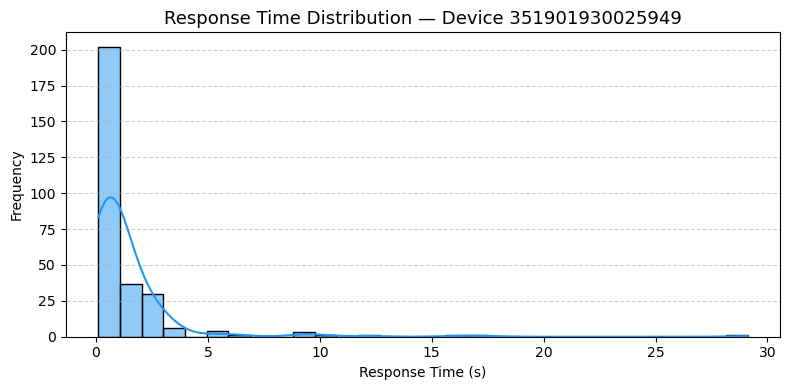

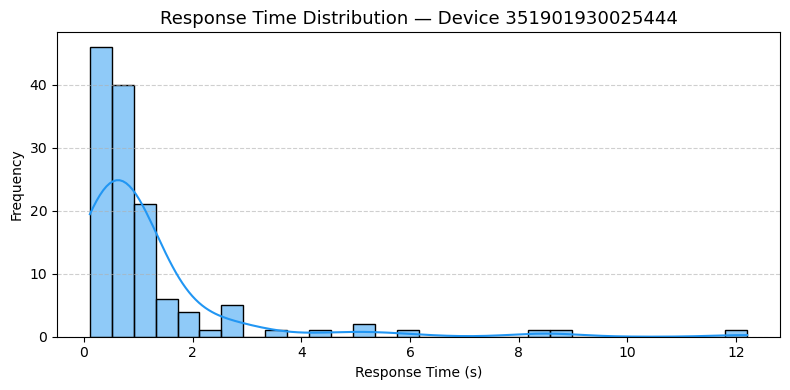

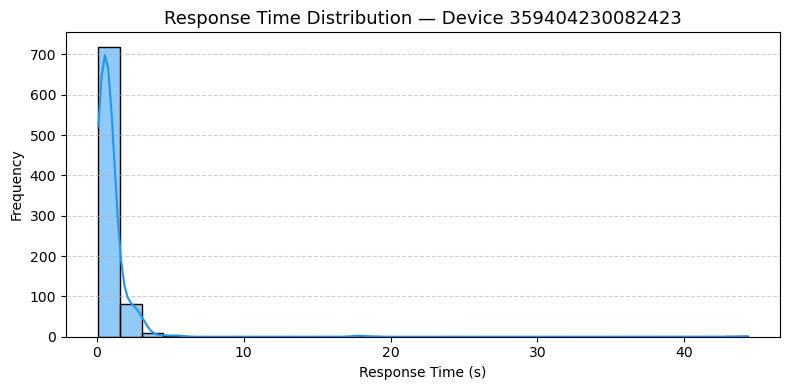

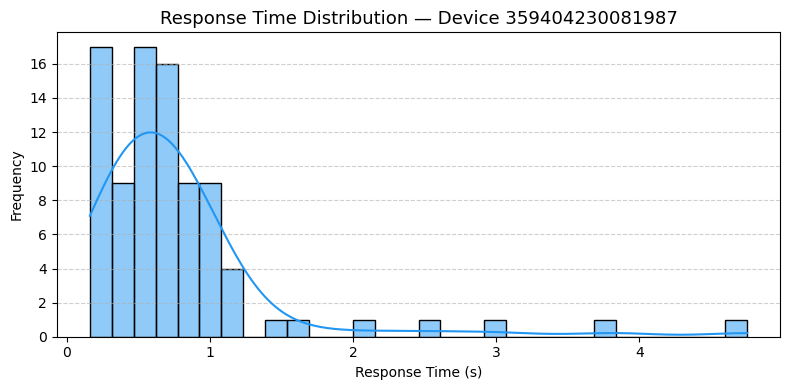

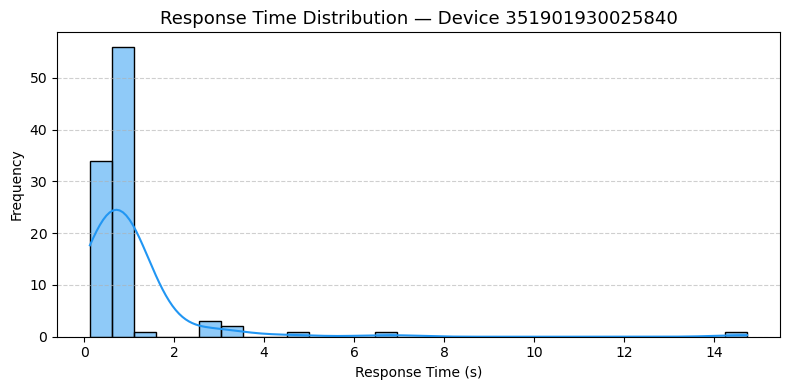

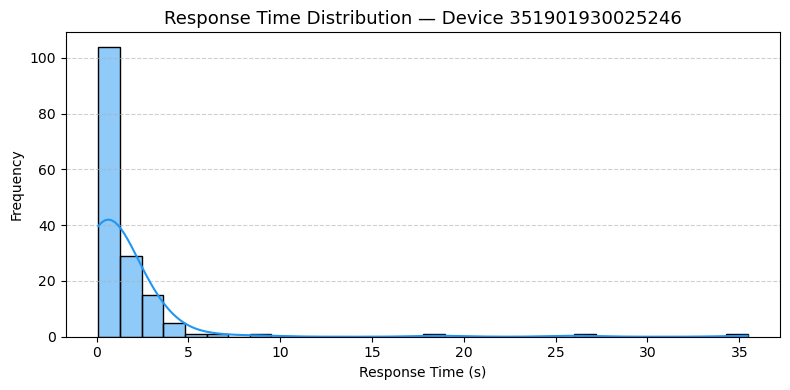

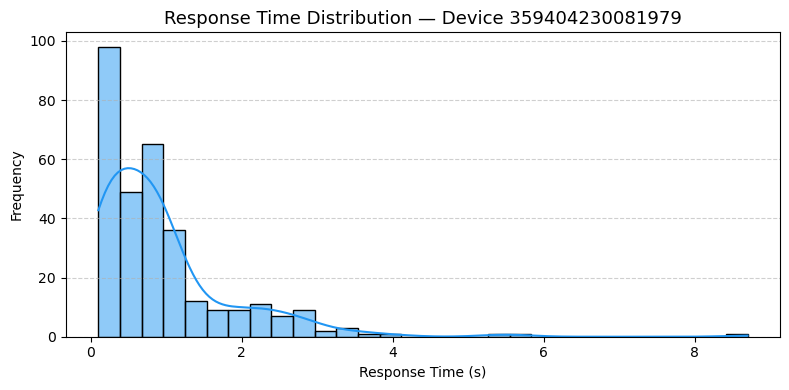

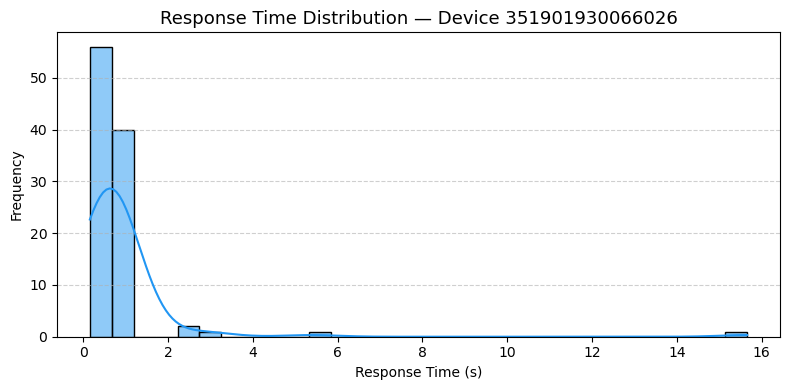

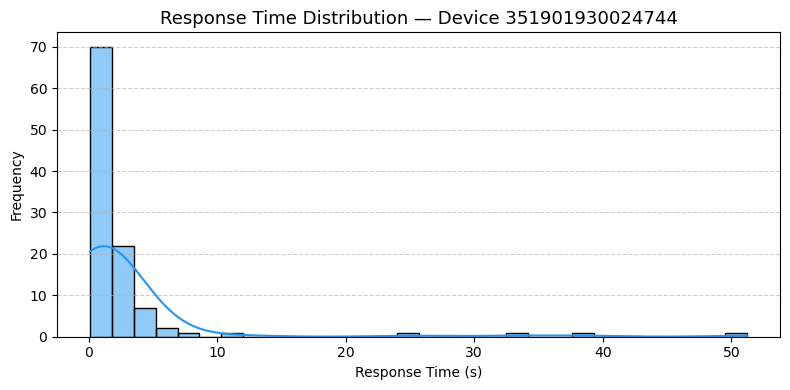

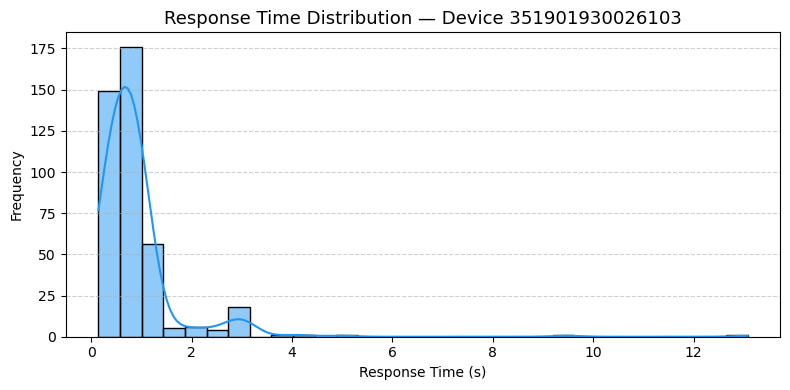

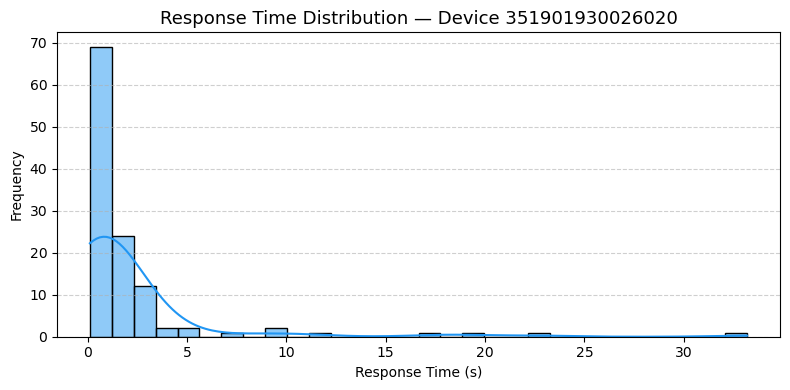

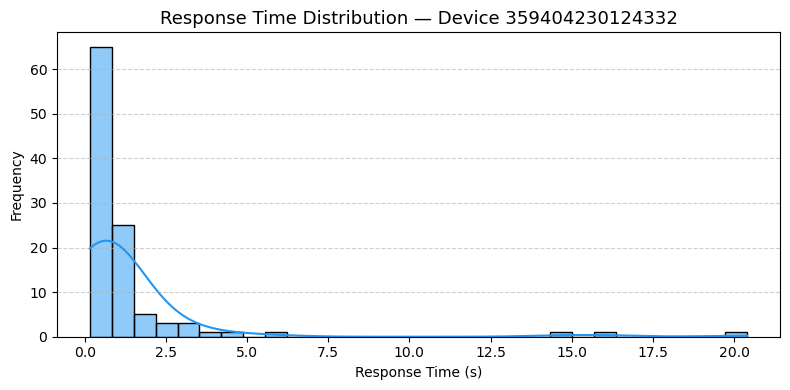

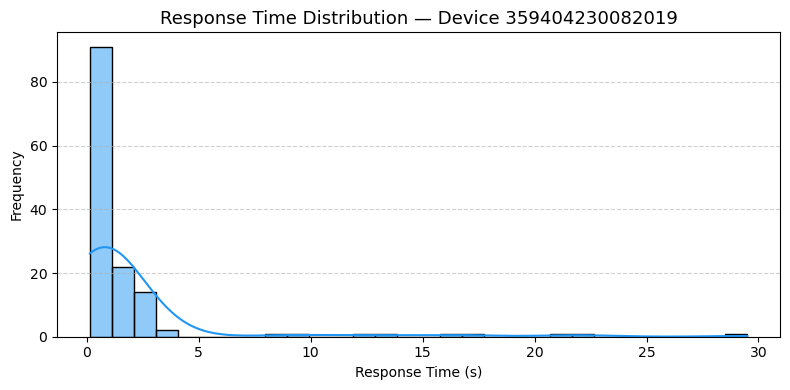

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load CSV
df = pd.read_csv("device_rpcs_unlocks_over_100.csv")


# Clean and prepare
df["uuid"] = df["uuid"].astype(str).fillna("Unknown")
df["response_time"] = pd.to_numeric(df["response_time"], errors="coerce")

# Drop rows without valid response times
df = df.dropna(subset=["response_time"])

# Unique devices
uuids = df["uuid"].unique()

# Plot distribution per device
for uuid in uuids:
    data = df[df["uuid"] == uuid]["response_time"]

    plt.figure(figsize=(8, 4))
    sns.histplot(data, kde=True, bins=30, color="#2196F3")
    plt.title(f"Response Time Distribution — Device {uuid}", fontsize=13)
    plt.xlabel("Response Time (s)")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


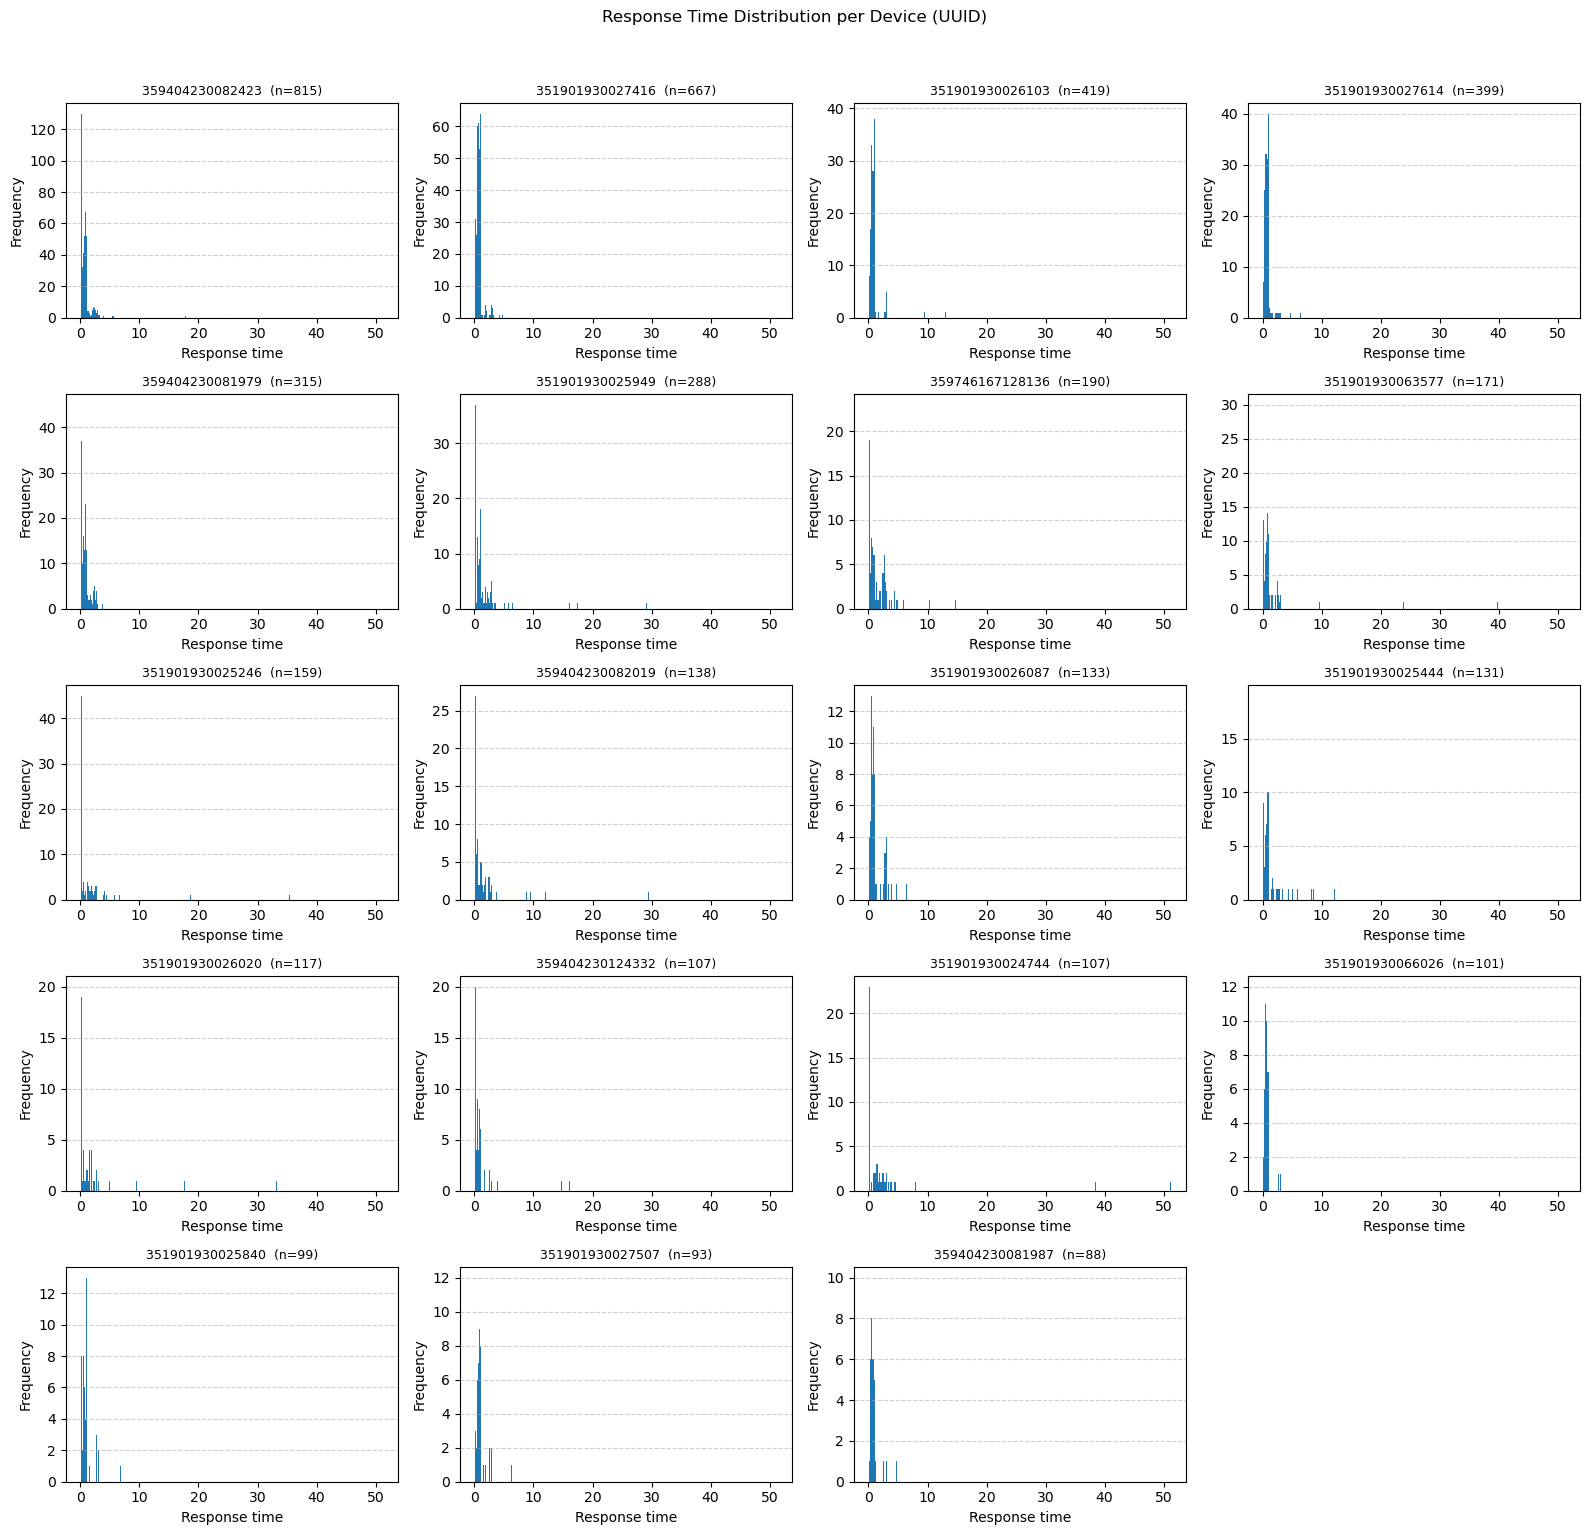

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


CSV_PATH = "device_rpcs_unlocks_over_100.csv"
UUID_COL = "uuid"
RT_COL = "response_time"   
N_COLS = 4                 # number of subplots per row

df = pd.read_csv(CSV_PATH)

# Prepare
df[UUID_COL] = df[UUID_COL].astype(str).fillna("Unknown")
df[RT_COL] = pd.to_numeric(df[RT_COL], errors="coerce")
df = df.dropna(subset=[RT_COL])

# Sort devices by number of records 
device_counts = df[UUID_COL].value_counts()
uuids = device_counts.index.tolist()

# Common bins across all data for comparability
global_bins = np.histogram_bin_edges(df[RT_COL].values, bins="auto")

# Grid size
n_devices = len(uuids)
n_cols = min(N_COLS, max(1, n_devices))
n_rows = math.ceil(n_devices / n_cols)

# Figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.0*n_cols, 3.0*n_rows), squeeze=False)

for i, uuid in enumerate(uuids):
    r, c = divmod(i, n_cols)
    ax = axes[r][c]
    data = df.loc[df[UUID_COL] == uuid, RT_COL]

    ax.hist(data, bins=global_bins)  # shared bins for fair comparison
    ax.set_title(f"{uuid}  (n={len(data)})", fontsize=9)
    ax.set_xlabel("Response time")
    ax.set_ylabel("Frequency")
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Turn off any extra axes
for j in range(n_devices, n_rows*n_cols):
    r, c = divmod(j, n_cols)
    axes[r][c].axis("off")

plt.suptitle("Response Time Distribution per Device (UUID)", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


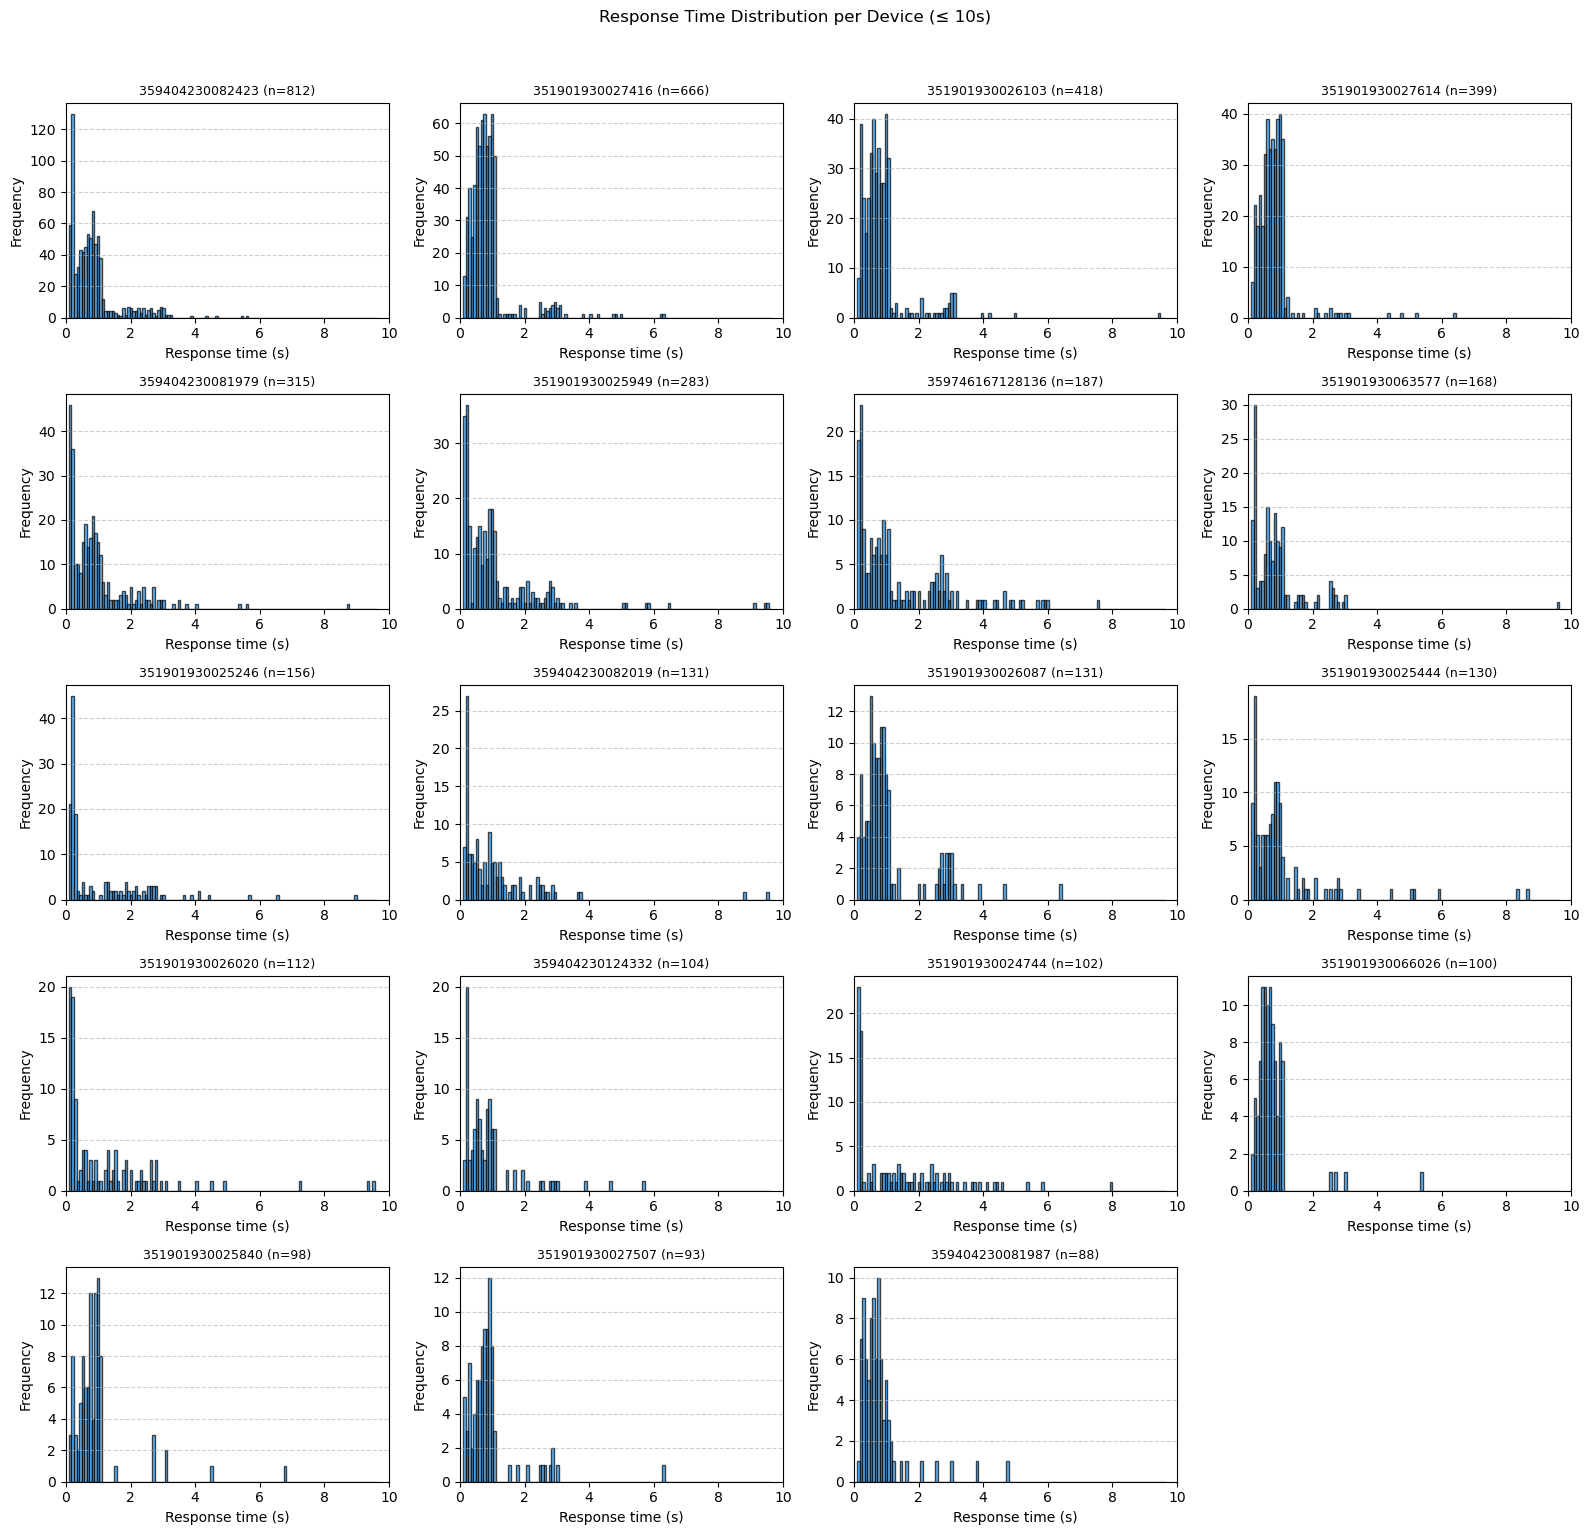

In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
CSV_PATH = "device_rpcs_unlocks_over_100.csv"
UUID_COL = "uuid"
RT_COL = "response_time"   # change if your column is named differently
N_COLS = 4                 # subplots per row
MAX_RESPONSE_TIME = 10     # seconds

# --- Load and prepare data ---
df = pd.read_csv(CSV_PATH)

# Check required columns
required = {UUID_COL, RT_COL}
if not required.issubset(df.columns):
    raise ValueError(f"CSV must contain columns: {required}")

# Clean and limit response times
df[UUID_COL] = df[UUID_COL].astype(str).fillna("Unknown")
df[RT_COL] = pd.to_numeric(df[RT_COL], errors="coerce")

# Keep only valid rows and filter by limit
df = df.dropna(subset=[RT_COL])
df = df[df[RT_COL] <= MAX_RESPONSE_TIME]

# Sort by count (optional — more data first)
device_counts = df[UUID_COL].value_counts()
uuids = device_counts.index.tolist()

# Create common bins (for consistent x-axis)
global_bins = np.histogram_bin_edges(df[RT_COL], bins="auto")

# Grid layout
n_devices = len(uuids)
n_cols = min(N_COLS, max(1, n_devices))
n_rows = math.ceil(n_devices / n_cols)

# --- Plot ---
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4.0 * n_cols, 3.0 * n_rows),
    squeeze=False
)

for i, uuid in enumerate(uuids):
    r, c = divmod(i, n_cols)
    ax = axes[r][c]
    data = df.loc[df[UUID_COL] == uuid, RT_COL]

    ax.hist(data, bins=global_bins, color="#2196F3", edgecolor="black", alpha=0.7)
    ax.set_title(f"{uuid} (n={len(data)})", fontsize=9)
    ax.set_xlabel("Response time (s)")
    ax.set_ylabel("Frequency")
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xlim(0, MAX_RESPONSE_TIME)  # keep x-axis consistent

# Turn off unused subplots
for j in range(n_devices, n_rows * n_cols):
    r, c = divmod(j, n_cols)
    axes[r][c].axis("off")

plt.suptitle(f"Response Time Distribution per Device (≤ {MAX_RESPONSE_TIME}s)", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\yulia\AppData\Local\Temp\ipykernel_25884\3656873201.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([UUID_COL, "rt_category"])


✅ Saved detailed response time summary with performance classification to 'response_time_summary_by_device.csv'
rt_category             uuid  <1 sec  1–5 sec  >5 sec  Total  % <1 sec  \
0            351901930024744      52       47       8    107      48.6   
1            351901930025246      99       54       6    159      62.3   
2            351901930025444     100       25       6    131      76.3   
3            351901930025840      75       22       2     99      75.8   
4            351901930025949     185       90      13    288      64.2   

rt_category  % 1–5 sec  % >5 sec Performance  
0                 43.9       7.5        Poor  
1                 34.0       3.8    Moderate  
2                 19.1       4.6    Moderate  
3                 22.2       2.0    Moderate  
4                 31.2       4.5    Moderate  


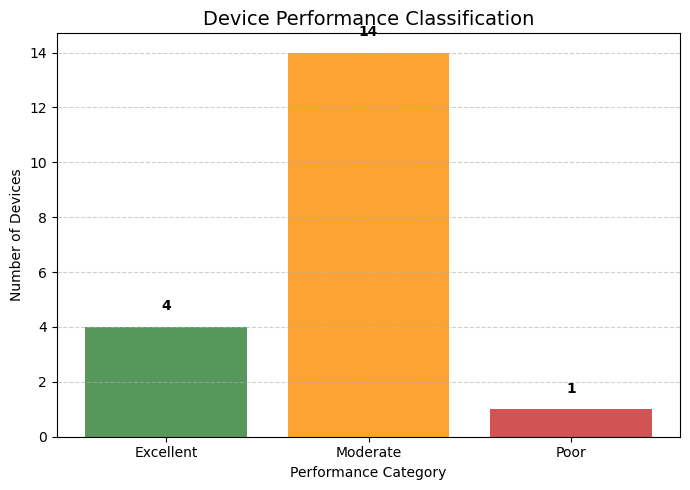

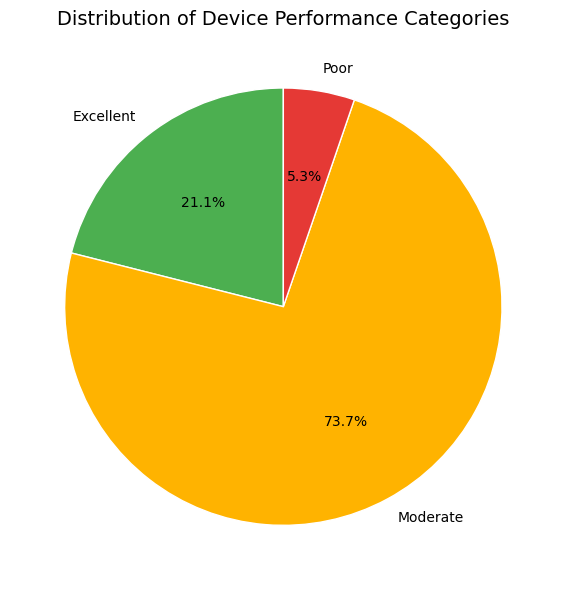

In [1]:
import pandas as pd

# --- Config ---
CSV_PATH = "device_rpcs_unlocks_over_100.csv"
UUID_COL = "uuid"
RT_COL = "response_time"
OUTPUT_FILE = "response_time_summary_by_device.csv"

# --- Load and clean data ---
df = pd.read_csv(CSV_PATH)

# Check required columns
required = {UUID_COL, RT_COL}
if not required.issubset(df.columns):
    raise ValueError(f"CSV must contain columns: {required}")

# Convert and clean
df[UUID_COL] = df[UUID_COL].astype(str).fillna("Unknown")
df[RT_COL] = pd.to_numeric(df[RT_COL], errors="coerce")
df = df.dropna(subset=[RT_COL])

# --- Categorize response times ---
df["rt_category"] = pd.cut(
    df[RT_COL],
    bins=[float("-inf"), 1, 5, float("inf")],
    labels=["<1 sec", "1–5 sec", ">5 sec"]
)

# --- Count per device and category ---
summary = (
    df.groupby([UUID_COL, "rt_category"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# --- Add total count ---
summary["Total"] = summary["<1 sec"] + summary["1–5 sec"] + summary[">5 sec"]

# --- Calculate percentages ---
summary["% <1 sec"] = 100 * summary["<1 sec"] / summary["Total"]
summary["% 1–5 sec"] = 100 * summary["1–5 sec"] / summary["Total"]
summary["% >5 sec"] = 100 * summary[">5 sec"] / summary["Total"]

# --- Round percentages ---
summary = summary.round({
    "% <1 sec": 1,
    "% 1–5 sec": 1,
    "% >5 sec": 1
})

# --- Classify performance ---
def classify_performance(pct_fast):
    if pct_fast >= 80:
        return "Excellent"
    elif pct_fast >= 50:
        return "Moderate"
    else:
        return "Poor"

summary["Performance"] = summary["% <1 sec"].apply(classify_performance)

# --- Save to CSV ---
summary.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Saved detailed response time summary with performance classification to '{OUTPUT_FILE}'")

# --- Preview first rows ---
print(summary.head())

import pandas as pd
import matplotlib.pyplot as plt

# --- Load the summary file created earlier ---
summary = pd.read_csv("response_time_summary_by_device.csv")

# Ensure column exists
if "Performance" not in summary.columns:
    raise ValueError("The summary file must contain a 'Performance' column. Run the previous step first.")

# --- Count devices by performance category ---
perf_counts = summary["Performance"].value_counts().reindex(["Excellent", "Moderate", "Poor"], fill_value=0)

# --- Bar chart ---
plt.figure(figsize=(7, 5))
bars = plt.bar(perf_counts.index, perf_counts.values, color=["#2E7D32", "#FB8C00", "#C62828"], alpha=0.8)
plt.title("Device Performance Classification", fontsize=14)
plt.xlabel("Performance Category")
plt.ylabel("Number of Devices")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, int(height),
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# --- Pie chart ---
plt.figure(figsize=(6, 6))
plt.pie(
    perf_counts.values,
    labels=perf_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#4CAF50", "#FFB300", "#E53935"],
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Distribution of Device Performance Categories", fontsize=14)
plt.tight_layout()
plt.show()
